In [1]:
!date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import hypergeom
import sys
sys.path.append('../GOCAM_Project/dev')
import os

import utils
import enrich
pd.options.display.max_colwidth = 100

Sun Oct  9 17:05:36 PDT 2022


# Comparing Set and Fully Flattened Methods on the Cancer Dataset

In [2]:
def drop_threshold(genes, cancer_test_set, uniprot2input, gocam_sizes, Dict, thresholds):
    results = {}
    for a in thresholds:
        r = set(enrich.enrich(genes, cancer_test_set, uniprot2input, gocam_sizes, Dict, alpha = a)[4].title.values)
        results[a]=r
    return results
    

In [3]:
gene_list = pd.read_csv('../../Desktop/GOCAM/cancer.csv',header=None,names = ['g'])
cancer_test_set, uniprot2input, not_converted = utils.convert_IDs(gene_list,'Gene Symbol')
x = pd.read_csv('../data/gocam_sizes_mouse.csv')
gocam_sizes = pd.Series(x.sizes.values,index=x.gocam)
Dict = utils.csv2dict('../data/ID2gocam_mouse.csv')

results = drop_threshold(list(gene_list.g), cancer_test_set, uniprot2input, gocam_sizes, Dict, [.05,.1,.15,.5])
c_set_05 = results[.05]
c_set_10 = results[.10]
c_set_15 = results[.15]
c_set_50 = results[.50]


In [4]:
gene_list = pd.read_csv('../../Desktop/GOCAM/cancer.csv',header=None,names = ['g'])
cancer_test_set, uniprot2input, not_converted = utils.convert_IDs(gene_list,'Gene Symbol')
x = pd.read_csv('../data/gocam_sizes_mouse_ff.csv')
gocam_sizes = pd.Series(x.sizes.values,index=x.gocam)
Dict = utils.csv2dict('../data/ID2gocam_mouse_ff.csv')

results = drop_threshold(list(gene_list.g), cancer_test_set, uniprot2input, gocam_sizes, Dict, [.05,.1,.15,.5])
c_ff_05 = results[.05]
c_ff_10 = results[.10]
c_ff_15 = results[.15]
c_ff_50 = results[.50]

The next two cells evaluate the set differences between the results at alpha = .05 post-multiple testing correction from the set method (cancer) and the fully flattened method (cancer_ff). All significance levels below are post-FDR correction.

First, we take the set difference of cancer and c_dif to obtain c_dif and vice versa to obtain c_ff_dif. Focusing on c_dif, we then ask if there is this set difference is created by some results being pushed just beyond the arbitrary threshold of .05 (ie from .04 to .06), which is practically not different. We generate cancer_ff_10, cancer_ff_15 and, cancer_ff_50 by rerunning enrichment with .10,.15, and .50 as significance cutoffs post-correction. We repeat the procedure of cancer-cancer_ff with cancer_ff_10,15,50 substituted for cancer_ff to see how far those highly significant results in the normal set method got pushed down the result list in the fully flattened method. The sequence of 8,7,5,5 means that the 5 results from set enrichment at .05 significance (post-correction) which are still not captured at .15 in the fully flattened metod are still not captured at .50. This suggests that set method of enrichment yields results that are completely missed by the fully flattened method. These 5 comprise a significant fraction of the 21 results yielded by the set method.

Conversely, when repeating the above procedure for the set difference between the fully flattened method and the set method, the sequence is 25,21,17,9. For reference, there are 38 results at .05 significance. Comparing 8/21 and 25/38, we see an increased proportion of unique results in a head to head comparison at .05 significance. (Keep in mind that unique results are not necessarily a good thing overall because it means that the enrichment results are sensitive to the method of representation). However, there steady decrease in the sequence from 25 to 21, to 17, to 9, and both reach a proportion of 25% uniqueness.

Regarding the uniqueness, this is largely produced by the increased gocam size (ie increasing from 13 to 122 genes is a huge penalty). To some extent, this can be mitigated by overcounting of sets, which I believe is responsible for the uniqueness of results from the fully flattened methods. However, there theoretically is another case in which the fully flattened method is superior due to the increased background size from ~4000 to ~5000 (many genes appear in gocams only in sets and this method allows them to contribute to the background when they wouldn't have done so in the set method). Consider a relatively large gocam with 15 genes and no sets (so the gocam size is 10 in both methods). Let's say that there is an overlap of 8 genes with the target set. With an decreased background size of 80% and naively using a binomial approximation of the solution, we have P(choose a gene to overlap from N)=N/M in the fully flattened method be 80% of the value for the set method. The complement probability P(not choosing a gene in N)=1-N/M is effectively unchanged because M>>N. Because we raise (N/M) and (1-N/M) to the power of k, we expect the ratio of  binomial probability via the two methods with different values for M to be (.80)^k. For larger k, the smaller background will be more significantly penalized. In the case of k=8, the ratio is .16, giving an advantage to the fully flattened method. This likely cannot account for more than a single order of magnitude difference in p value for the overwhelming majority of gocams, as they tend to be small in size, but it may become a concern if multiple gocams are linked together into larger models



In [5]:
c_set_05-c_ff_05

{'ERBB2 Regulates Cell Motility - Reactome',
 'G beta:gamma signalling through PI3Kgamma - Reactome',
 'MAP2K and MAPK activation - Reactome',
 'PD-1 signaling - Reactome',
 'PI3K/AKT activation - Reactome',
 'PLCG1 events in ERBB2 signaling - Reactome',
 'Role of LAT2/NTAL/LAB on calcium mobilization - Reactome',
 'Role of phospholipids in phagocytosis - Reactome'}

In [6]:
c_ff_05-c_set_05

{'Activated NTRK3 signals through PI3K - Reactome',
 'Activation of NOXA and translocation to mitochondria - Reactome',
 'Activation of PUMA and translocation to mitochondria - Reactome',
 'Attenuation phase - Reactome',
 'Cyclin D associated events in G1 - Reactome',
 'Cyclin E associated events during G1/S transition - Reactome',
 'FLT3 Signaling - Reactome',
 'Fanconi Anemia Pathway - Reactome',
 'Formation of Incision Complex in GG-NER - Reactome',
 'GAB1 signalosome - Reactome',
 'HDR through Single Strand Annealing (SSA) - Reactome',
 'Inhibition of replication initiation of damaged DNA by RB1/E2F1 - Reactome',
 'MET activates PI3K/AKT signaling - Reactome',
 'Nuclear events mediated by NFE2L2 - Reactome',
 'Oxidative Stress Induced Senescence - Reactome',
 'PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling - Reactome',
 'Processing of DNA double-strand break ends - Reactome',
 'RAF activation - Reactome',
 'RAF/MAP kinase cascade - Reactome',
 'RUNX1 regulates genes involved in me

In [7]:
len(c_set_05-c_ff_05),len(c_set_05-c_ff_10),len(c_set_05-c_ff_15),len(c_set_05-c_ff_50),len(c_set_05)

(8, 7, 5, 5, 21)

In [8]:
len(c_ff_05 -c_set_05),len(c_ff_05- c_set_10),len(c_ff_05- c_set_15),len(c_ff_05- c_set_50),len(c_ff_05)

(25, 21, 17, 9, 38)

The next 3 cells investigate the relative and absolute changes in gocam size that result from the set method. On average, there is mean 22% reduction in gocam size, with a 75th percentile change of 40% and a 50th percentile change of 6%. Based on this, a significant proportion of models could greatly benefit from set representation.

In [9]:
x1 = pd.read_csv('../data/gocam_sizes_mouse.csv')
x2 = pd.read_csv('../data/gocam_sizes_mouse_ff.csv')
d = pd.Series(x2.sizes.values,index=x2.gocam).to_dict()
x1['sizes_ff'] = x1.gocam.apply(lambda x: d.get(x,'F'))
x1 = x1.query('sizes_ff != "F"')
x1['diff'] = x1['sizes_ff'] - x1['sizes']
x1.query('diff < 0')


,gocam,sizes,sizes_ff,diff
159,http://model.geneontology.org/R-HSA-156581,18,17,-1
164,http://model.geneontology.org/R-HSA-6783783,17,16,-1
236,http://model.geneontology.org/R-HSA-1614635,13,12,-1
328,http://model.geneontology.org/R-HSA-2485179,9,8,-1
413,http://model.geneontology.org/R-HSA-8983711,8,6,-2
519,http://model.geneontology.org/R-HSA-351202,6,5,-1
619,http://model.geneontology.org/R-HSA-180292,5,4,-1


In [10]:
#absolute difference
s = x1['diff']
s = pd.to_numeric(s)
s.describe().apply(lambda x: int(x))

count    1211
mean        7
std        22
min        -2
25%         0
50%         1
75%         4
max       279
Name: diff, dtype: int64

In [11]:
#relative difference
s1 = -x1['diff']/x1['sizes_ff']*100
s1 = pd.to_numeric(s1)
s1.describe().apply(lambda x: int(x))

count    1211
mean      -22
std        28
min       -98
25%       -40
50%        -6
75%         0
max        33
dtype: int64

In [12]:
#setID2members.get('sset:EPH-ephrin oligomers')

# Repeating analysis across all datasets

In [13]:
x_s = pd.read_csv('../data/gocam_sizes_mouse.csv')
gocam_sizes_s = pd.Series(x_s.sizes.values,index=x_s.gocam)
Dict_s = utils.csv2dict('../data/ID2gocam_mouse.csv')

x_ff = pd.read_csv('../data/gocam_sizes_mouse_ff.csv')
gocam_sizes_ff = pd.Series(x_ff.sizes.values,index=x_ff.gocam)
Dict_ff = utils.csv2dict('../data/ID2gocam_mouse_ff.csv')

path = '../../Desktop/GOCAM/'
datasets = {'cancer.csv':'Gene Symbol','gastric_cancer.csv':'ENSEMBL ID','bladder_cancer.csv':'ENSEMBL ID','parkinson.csv':'Gene Symbol'}
results_combined_s = [0,0,0,0,0]
results_combined_ff = [0,0,0,0,0]
for dataset, symbol_type in datasets.items():
    gene_list = pd.read_csv(os.path.join(path,dataset),header=None,names = ['g'])
    test_set, uniprot2input, not_converted = utils.convert_IDs(gene_list,symbol_type)
    
    results = drop_threshold(list(gene_list.g), test_set, uniprot2input, gocam_sizes_s, Dict_s, [.05,.1,.15,.5])
    c_set_05 = results[.05]
    c_set_10 = results[.10]
    c_set_15 = results[.15]
    c_set_50 = results[.50]

    results = drop_threshold(list(gene_list.g), test_set, uniprot2input, gocam_sizes_ff, Dict_ff, [.05,.1,.15,.5])
    c_ff_05 = results[.05]
    c_ff_10 = results[.10]
    c_ff_15 = results[.15]
    c_ff_50 = results[.50]
    
    results_combined_s[0]+=len(c_set_05-c_ff_05)
    results_combined_s[1]+=len(c_set_05-c_ff_10)
    results_combined_s[2]+=len(c_set_05-c_ff_15)
    results_combined_s[3]+=len(c_set_05-c_ff_50)
    results_combined_s[4]+=len(c_set_05)
    
    results_combined_ff[0]+=len(c_ff_05-c_set_05)
    results_combined_ff[1]+=len(c_ff_05-c_set_10)
    results_combined_ff[2]+=len(c_ff_05-c_set_15)
    results_combined_ff[3]+=len(c_ff_05-c_set_50)
    results_combined_ff[4]+=len(c_ff_05)
results_combined_s,results_combined_ff   
        

([38, 35, 32, 28, 58], [44, 35, 24, 12, 64])

# Examining PI3K/AKT signaling in the P97 dataset

In [14]:
gene_list = pd.read_csv('../../Desktop/GOCAM/P97.csv',header=None,names = ['g'])
P97_test_set = gene_list.g
uniprot2input = pd.Series(P97_test_set.values,index=P97_test_set).to_dict()
x = pd.read_csv('../data/gocam_sizes_mouse.csv')
gocam_sizes = pd.Series(x.sizes.values,index=x.gocam)
Dict = utils.csv2dict('../data/ID2gocam_mouse.csv')
filtered_out_genes, filtered_list, setID2members_input_uni, setID2members_input, df_display= enrich.enrich(list(gene_list.g), P97_test_set, uniprot2input, gocam_sizes, Dict,alpha = .05)
df_display#[df_display.title.apply(lambda x: 'Hedgehog' in x)]

,title,pval (uncorrected),# genes in list,#genes in gocam,shared gene products in gocam,url
0,"PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling - Reactome",0.000002,8,13,"[sset:PIP5K1A/B, sset:PI4K2A/2B, sset:PP2A-subunit A, sset:SYNJ/MTM(1), sset:Activator:PI3K, sse...",http://model.geneontology.org/R-HSA-6811558
1,Unwinding of DNA - Reactome,0.000002,6,7,"[P25205, Q14566, P33991, P49736, P33993, P33992]",http://model.geneontology.org/R-HSA-176974


In [15]:
len(gene_list.g),len(filtered_list),len(filtered_out_genes)

(766, 338, 496)

In [16]:
#hypergeom.sf(count-1, background_gene_list_size,  gocam_size, gene_list_size)
hypergeom.sf(8-1, 5386,  122, 270),hypergeom.sf(8-1, 4008,  13, 338)

(0.2673159657624832, 2.085287471110162e-06)

# HGT is sensitive to relatively small parameter changes

Comparing enrichment of 'SCF(Skp2)-mediated degradation of p27/p21 - Reactome' in the P97 dataset in the fully flattened and set models:

In [17]:
#hypergeom.sf(count-1, background_gene_list_size,  gocam_size, gene_list_size)
hypergeom.sf(13-1, 5386,  51, 270),hypergeom.sf(12-1, 4008,  50, 318)

(8.116740023877458e-07, 0.0003898627483820106)

Effect of gene list size (change from 270 to 318 is due to addition of sets - removal of genes that only occur in sets)

In [18]:
#hypergeom.sf(count-1, background_gene_list_size,  gocam_size, gene_list_size)
hypergeom.sf(13-1, 5386,  51, 270),hypergeom.sf(12-1, 4008,  50, 270)

(8.116740023877458e-07, 8.212821239278383e-05)

Effect of background gene list size (analogous to above)

In [19]:
#hypergeom.sf(count-1, background_gene_list_size,  gocam_size, gene_list_size)
hypergeom.sf(13-1, 5386,  51, 270),hypergeom.sf(12-1, 5386,  50, 270)

(8.116740023877458e-07, 4.33261197373605e-06)

# Examining the Effect of Background Size

Background size refers to the number of entities across all models, and when the blue curve is below the orange, the result is "automatically" significant by itself at rank 5 or higher (higher being closer to 1), meaning its significance does not depend on the p-values of the rest of the results (see below). 

Caption and parameters: Blue = uncorrected p-value, orange = Benjamini-Hochberg critical value for rank 5 ( from multiple testing correction).
Alpha=.05. The number of GO CAMs (for multiple testing correction) is calculated as background gene list size / average gocam size, which I arbitrarily set equal to 5. I assume that the background list of genes increases due to the addition of more models, which increases the number of tests being done. Thus, the BH critical value is not constant and decreases with background size.

In [20]:
import numpy as np

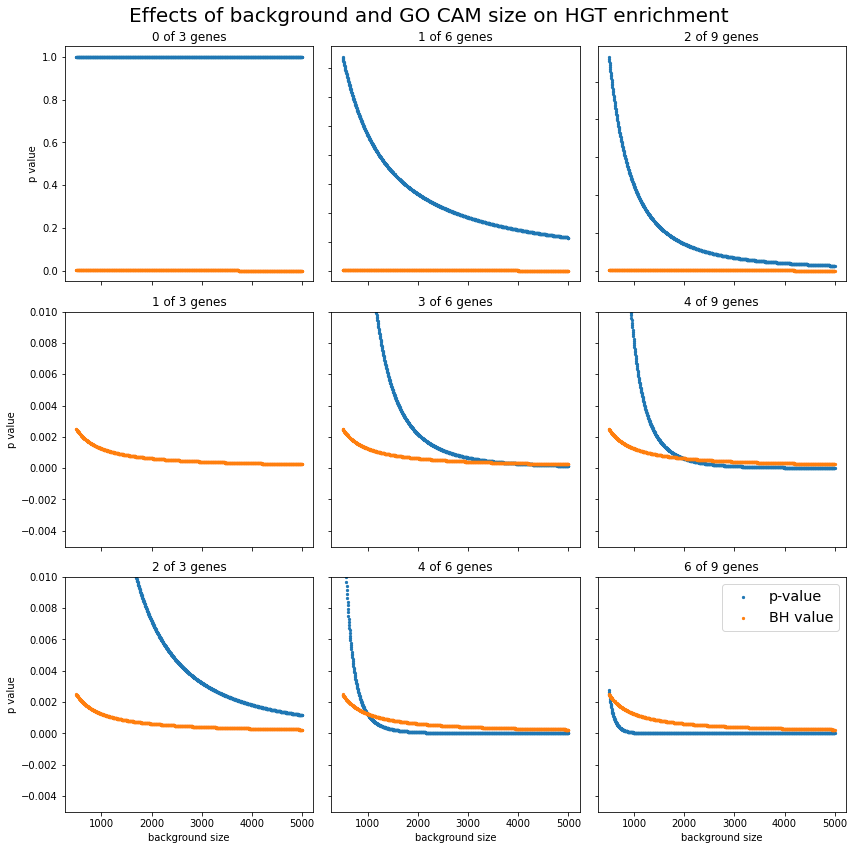

In [21]:
background_gene_list_size = np.linspace(500,5000,1000)
average_gocam_size = 5
total_gocam_sizes = background_gene_list_size*(1/average_gocam_size)
alpha = .05
rank = 5
crit_vals = 1/background_gene_list_size*alpha*rank*average_gocam_size
count_percent = [.3,.5,.7]
gocam_size = [3,6,9]
gene_list_size = 100
fig, axs = plt.subplots(3, 3,figsize=(12,12))
fig.suptitle('Effects of background and GO CAM size on HGT enrichment',fontsize=20)
#txt="""Blue = uncorrected p-value, orange = benjamini-hochberg critical value for rank 5 (multiple hypothesis correction). \n
#Alpha=.05 for multiple testing correction. The number of gocams is calculated as background gene list size / average gocam size, which is 5."""
#plt.figtext(0.5, 0, txt,  horizontalalignment='center', fontsize=14)
for i in range(0,3):
    for j in range(0,3):
        pvals=[]
        for x in background_gene_list_size:
            num = int(count_percent[i]*gocam_size[j])
            pvals.append(hypergeom.sf(num-1, x,  gocam_size[j], gene_list_size))
        axs[i,j].scatter(background_gene_list_size,pvals,s=5, label = 'p-value')
        axs[i,j].scatter(background_gene_list_size,crit_vals, s=5,label = 'BH value')
        axs[i,j].set_title(str(num)+' of '+str(gocam_size[j])+ ' genes')
        if i==2 and j==2: axs[i,j].legend(fontsize='x-large')
        #axs[i,j].axhline(y=(alpha))
        if i == 1:
            axs[i,j].set_ylim([-0.005, 0.01])
        if i == 2:
            axs[i,j].set_ylim([-.005, 0.01])
for ax in axs.flat:
    ax.set(xlabel='background size', ylabel='p value')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
fig.patch.set_facecolor('xkcd:white')
plt.savefig('../../Desktop/Effect_list_sizes',dpi=300)